In [92]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.impute import SimpleImputer

# Načítanie a úprava dát z csv súborov.
V prvej fáze sme zanalyzovali, v ktorých stĺpcoch sa nachádzajú aké unikátne hodnoty. Tie, ktoré nám nič nehovorili ako napríklad otázniky sme nahradili hodnotami np.nan aby sa nám jednoduchšie nahrádzali, pretože k nim môžeme pristupovať ako ku chýbajúcim hodnotám. V prípade, keď stĺpec obsahoval viacero hodnôt, ktoré hovorili to isté, len boli inak napísené, tak sme ich nahradili jednotným označním(napríklad 'f', 'F', 'False' majú teraz jednotné označenie 'False'). 

V datasete sa objavovali aj duplikáty, ktoré sme zistili na základe mena, pričom jeden zo záznamov mal v niektorých atribútoch chýbajúce hodnoty a druhý mal validné dáta. Pomocou classy DropDuplicates sme tieto chýbajúce hodnoty nahradili, z čoho nám vznikli dva rovnaké záznamy, ktoré sme na konci dropli, pretože to boli duplikáty.

Osobám, ktorým chýbal vek sme ho vypočítali z dátumu narodenia a to nasledujúcim spôsobom. Najprv sme extrahovali rok narodenia z atribútu date_of_birth. Následne sme vytvorili pre tieto hodnoty samostatný column s názvom year_of_birth. Tým pádom sme stĺpec date_of_birth mohli dropnúť a pomocou atribútu year_of_birth vypočítať aktuálny vek osoby.

Adresu sme rozdelili na stĺpce street, city a zip_code. Vzhľadom na to, že v stĺpci zip_code nie sú chýbajúce hodnoty, tak sme mohli dropnúť stĺpce street a city. Zip_code nemal jednotný formát, tak sme ho upravili tým spôsobom, že sme  z neho nechali iba čísla.

In [93]:
# This class is used for personal and other dataset
class MySpritClass(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        for column_name in X:
            if X[column_name].dtypes == 'object':
                X[column_name] = X[column_name].str.strip()
        return X

# This class is used for other dataset    
class MyAdjustClass(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X['marital-status'] = X['marital-status'].replace('??', np.nan)
        X['occupation'] = X['occupation'].replace('?', np.nan)
        X['pregnant'] = X['pregnant'].replace(['f', 'F', 'FALSE'], 'False')
        X['pregnant'] = X['pregnant'].replace(['t', 'T', 'TRUE'], 'True')
        X['relationship'] = X['relationship'].replace('Not_in_family', 'Not-in-family')
        X['relationship'] = X['relationship'].replace('Own_child', 'Own-child')
        X['relationship'] = X['relationship'].replace('Other_relative', 'Other-relative')
        X['native-country'] = X['native-country'].replace('?', np.nan)
        X['workclass'] = X['workclass'].replace('?', np.nan)
        
        return X

# This class is used for other dataset
class SeparateAndDeleteMedicalInfo(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X = self.separate_and_delete_medical_info(X)
        return X
    
    def separate_and_delete_medical_info(self, dataframe):
        df2 = pd.DataFrame() 
        # Iterate through every row and take values from medical_info column
        for _,column_data in dataframe['medical_info'].iteritems(): 
            if isinstance(column_data, str): # If value isn't nan
                column_data = column_data[1:-1] # Delect curly brackets from start and end of string
                column_data_split = column_data.split(',') # Split string by comma

                row = {} 
                for name_value in column_data_split: # Iterate through split string
                    name_value_split = name_value.split(':') # Split into name of column and value of column
                    # Store value into dictionary with name of the column as a key
                    row[name_value_split[0][1:-1]] = [np.float(name_value_split[1][1:-1])] # Get rid of '' by [1:-1]

                row_data_frame = pd.DataFrame(row) # Convert dictionary into DataFrame
                df2 = df2.append(row_data_frame, ignore_index=True) # Append row_data_frame into df2
            else: # Value is nan, append nan row into df2
                df2 = df2.append(pd.Series(np.nan), ignore_index=True)

        df2 = df2.drop(columns=[0]) # Drop last column

        # Add values from df2 to main df
        for column_name in df2.columns:
            dataframe[column_name] = df2[column_name]

        del dataframe['medical_info'] # medical info is already divided into another columns, so we can erase it

        return dataframe

# This class is used for personal dataset
class SeparateAndDeleteAddress(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X = self.separate_and_delete_address(X)
        return X
    
    def separate_and_delete_address(self, dataframe):
        df_addresses = dataframe['address'].replace('\r', ',', regex=True)
        df_addresses = df_addresses.replace('\n', ' ', regex=True)
        df_addresses = df_addresses.str.split(',')

        cities = []
        streets = []
        zip_codes = []

        for address in df_addresses:
            if len(address) < 3: # these records have cities in address
                streets.append(address[0])
                cities.append(None)
                zip_codes.append(address[1])
            else: # these records don't have cities in address
                streets.append(address[0])
                cities.append(address[1])
                zip_codes.append(address[2])

        dataframe['street'] = streets
        dataframe['city'] = cities
        dataframe['zip_code'] = zip_codes

        dataframe = dataframe.drop('address', axis=1)

        return dataframe
    
# This class is used for joined dataset    
class DropDuplicates(BaseEstimator, TransformerMixin): 
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X = self.drop_duplicates(X)
        return X
    
    def drop_duplicates(self, data_frame):
        df1 = data_frame[data_frame.duplicated('name', keep=False)].sort_values('name')

        for i in range(0,len(df1.index),2):
            for (column_name1, column_data1), (_, column_data2) in zip(df1.iloc[i].iteritems(), df1.iloc[i + 1].iteritems()):
                if pd.isnull(column_data1):
                    data_frame.loc[df1.iloc[i]['name'] == data_frame['name'], column_name1] = column_data2
                else:
                    data_frame.loc[df1.iloc[i]['name'] == data_frame['name'], column_name1] = column_data1

        data_frame = data_frame.drop_duplicates()

        return data_frame
    
# This class is used for joined dataset    
class ExtractYear(BaseEstimator, TransformerMixin): 
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X = self.extract_year(X)
        return X
    
    def extract_year(self, data_frame):
        years = []
        for cell in data_frame['date_of_birth']:
            if re.match('^[0-9]{2}\-[0-9]{2}\-[0-9]{2}$', cell):
                year = cell[:2]
                years.append(int('19' + year))
            elif re.match('[0-9]{4}', cell):
                years.append(int(re.findall('[0-9]{4}', cell)[0]))
            elif re.match('^[0-9]{2}\/[0-9]{2}\/[0-9]{4}$', cell):
                years.append(int(cell[-4:]))

        data_frame['year_of_birth'] = years

        return data_frame.drop(columns=['date_of_birth'])
    
# This class is used for joined dataset    
class CalculateAgeFromYear(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X = self.calculate_age_from_year(X)
        return X
    
    def calculate_age_from_year(self, data_frame):
        new_age = []
        for (age, data1), (year, data2) in zip(data_frame['age'].iteritems(), data_frame['year_of_birth'].iteritems()):
            if pd.isnull(data1):
                new_age.append(2020 - data2)
            else:
                new_age.append(data1)

        data_frame['age'] = new_age

        return data_frame
    
# This class is used for joined dataset    
class GetNumberFromZipCodeDropCityStreet(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X = self.get_number_from_zip_code(X)
        X = X.drop('city', axis=1)
        X = X.drop('street', axis=1)
        return X
    
    def get_number_from_zip_code(self, dataframe):
        zip_numbers = []
        for zip_code in dataframe['zip_code']:
            zip_numbers.append(int(re.findall('[0-9]{4}', zip_code)[0]))

        dataframe['zip_code'] = zip_numbers
        
        return dataframe    

## Úprava other datasetu
Už pri načítaní sme dropli prvý stĺpec, ktorý nič nehovoril, pretože bol Unnamed. Následne sme aplikovali sprit na atribúty, ktoré boli typu object, aby sa s nimi lepšie pracovalo a mohli sme ich upraviť na jednotný formát. Potom sme zmenili označenie atribútov, ktoré mali tú istú hodnotu, len vyjadrenú iným formátom. Ako poslednú úpravu pre tento dataset sme rozdelili object medical info na stĺpce mean_oxygen, std_oxygen, kurtosis_oxygen a skewness_oxygen.

In [94]:
# other_train
df_other = pd.read_csv('./other_train.csv', sep=',', index_col=0) # First column is Unnamed

other_pipe = Pipeline(steps = [
    ('Sprit', MySpritClass()),
    ('Adjust', MyAdjustClass()),
    ('Separate and delete medical info', SeparateAndDeleteMedicalInfo())
])

df_other = other_pipe.transform(df_other)

## Úprava personal datasetu
V tomto prípade sme tiež mohli dropnúť už pri načítaní stĺpec Unnamed. Tiež sme vykonali sprit na atribúty typu object a zložený atribút address sme rozdelili na atribúty street, city a zip_code.

In [95]:
# personal_train
df_personal = pd.read_csv("./personal_train.csv", index_col=0, sep=',') # First column was Unnamend

personal_pipe = Pipeline(steps = [
    ('Sprit', MySpritClass()),
    ('Separate and delete address', SeparateAndDeleteAddress())
])

df_personal = personal_pipe.transform(df_personal)

## Join datasetov
Po samostatnej úprave datasetov sme ich joinli podľa mena a dropli stĺpec address, ktorý bol z datasetu other, pretože sme ho mali rozložený na atribúty street, city a zip_code.

In [96]:
df_joined = df_other.merge(df_personal, on='name', how='left') # join other train and personal train on name
del df_joined['address'] # we can also erase disgusting address column, because we have it in detail from personal train

## Úprava joinutého datasetu
Na joinutom datasete bolo potrebné vyriešiť problém s duplikátmi, výpočet aktuálneho veku pre osoby, ktoré ho v zázname nemali uvedený a úprava zip_code na jednotný formát. Tieto procesy sú bližšie opísane na začiatku tejto kapitoly.

In [97]:
joined_pipe = Pipeline(steps = [
    ('Drop duplicates', DropDuplicates()),
    ('Extract year', ExtractYear()),
    ('Calculate age from year and drop date_of_birth', CalculateAgeFromYear()),
    ('Get numbers from zip_code and drop city and street', GetNumberFromZipCodeDropCityStreet())
])

df_joined = joined_pipe.transform(df_joined)

<ipython-input-93-069f6547d23e>:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['year_of_birth'] = years


Síce tu vyhodí warning, ale spraví to, čo má.

In [98]:
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3933 entries, 0 to 3982
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              3933 non-null   object 
 1   race              3933 non-null   object 
 2   marital-status    3540 non-null   object 
 3   occupation        3710 non-null   object 
 4   pregnant          3933 non-null   object 
 5   education-num     3932 non-null   float64
 6   relationship      3933 non-null   object 
 7   skewness_glucose  3932 non-null   float64
 8   mean_glucose      3933 non-null   float64
 9   capital-gain      3931 non-null   float64
 10  kurtosis_glucose  3933 non-null   float64
 11  education         3933 non-null   object 
 12  fnlwgt            3931 non-null   float64
 13  class             3933 non-null   float64
 14  std_glucose       3931 non-null   float64
 15  income            3933 non-null   object 
 16  native-country    3874 non-null   object 


Výpočtom veku pre záznamy, ktoré ho nemali sme si ušetrili robotu pri náhradzaní chýbajúcich hodnôt.

In [99]:
df_joined.describe()

,education-num,skewness_glucose,mean_glucose,capital-gain,kurtosis_glucose,fnlwgt,class,std_glucose,hours-per-week,capital-loss,mean_oxygen,std_oxygen,kurtosis_oxygen,skewness_oxygen,age,zip_code,year_of_birth
count,3932.000000,3932.000000,3933.000000,3931.000000,3933.000000,3.931000e+03,3933.000000,3931.000000,3932.000000,3932.000000,3932.000000,3932.000000,3932.000000,3932.000000,3933.000000,3933.000000,3933.000000
mean,10.073245,4.219811,63.696776,1237.183160,0.951283,1.911450e+05,0.255276,45.172534,40.535097,73.980671,18.479727,31.152712,7.414067,91.315050,51.936435,5026.287567,1966.993389
std,2.674246,9.679145,3358.120098,8659.340002,1.610970,1.073383e+05,0.436072,7.608810,12.301212,371.308180,34.793133,22.269962,4.812653,108.560937,11.820871,2871.409016,11.820308
min,1.000000,-1.755332,-18973.437500,0.000000,-1.641515,1.882700e+04,0.000000,25.695250,1.000000,0.000000,0.213211,7.370432,-2.597872,-1.976976,-1.000000,52.000000,1906.000000
25%,9.000000,-0.120081,83.859375,0.000000,0.072144,1.179345e+05,0.000000,40.163947,40.000000,0.000000,2.064799,15.039457,3.636259,12.863954,45.000000,2498.000000,1959.000000
50%,10.000000,0.374657,110.539062,0.000000,0.310784,1.795120e+05,0.000000,45.869299,40.000000,0.000000,3.234532,20.564154,7.783017,68.505049,52.000000,5018.000000,1967.000000
75%,13.000000,2.083826,125.359375,0.000000,0.776762,2.416740e+05,1.000000,50.361097,45.000000,0.000000,12.635452,43.229414,10.263412,127.017151,60.000000,7527.000000,1974.000000
max,16.000000,68.101622,15887.500000,99999.000000,8.069522,1.366120e+06,1.000000,91.206475,99.000000,2824.000000,217.371238,110.642211,34.539844,1191.000837,113.000000,9994.000000,2020.000000


In [100]:
df_joined.head()

,name,race,marital-status,occupation,pregnant,education-num,relationship,skewness_glucose,mean_glucose,capital-gain,...,capital-loss,workclass,mean_oxygen,std_oxygen,kurtosis_oxygen,skewness_oxygen,age,sex,zip_code,year_of_birth
0,David Hayes,Black,NaN,Prof-specialty,False,5.0,Not-in-family,-0.197692,141.359375,0.0,...,0.0,Private,4.042642,19.456469,6.410765,49.813954,45.0,Female,1952,1974
1,Stanley Benny,White,Married-civ-spouse,Exec-managerial,False,13.0,Husband,16.019670,53.968750,0.0,...,0.0,Private,9.294314,35.958174,4.424007,19.868969,42.0,Male,2201,1977
2,Domingo Labriola,Asian-Pac-Islander,Married-civ-spouse,Farming-fishing,False,3.0,Husband,21.803837,2257.812500,0.0,...,0.0,Private,138.787625,79.152788,-0.445270,-0.909086,46.0,Male,4180,1973
3,Ronnie Moore,White,Never-married,Other-service,False,10.0,Not-in-family,-0.112191,110.046875,0.0,...,0.0,Private,3.100334,17.819373,8.434320,85.665564,53.0,Male,3273,1966
4,Victor Mcjunkin,White,NaN,Adm-clerical,False,10.0,Not-in-family,-0.309642,137.960938,0.0,...,0.0,Private,4.203177,23.949006,6.531796,45.866688,52.0,Female,7107,1967


## Zhrnutie
Po tejto fáze majú hodnoty jednotlivých atribútov jednotný formát, čo bolo našim cieľom. Pri ich úprave sme využili Pipeline z sklearn, taktiež sme vytvorili vlastné classy a funkcie na úpravu dáta, takže riešenie je znovu použitelné aj na testovacie dáta.

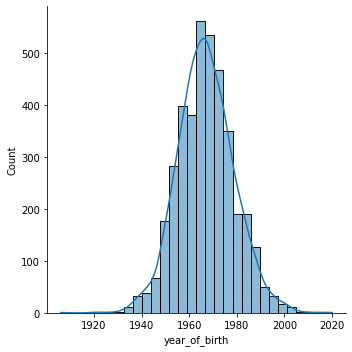

In [101]:
sns.displot(df_joined['year_of_birth'], kde=True, bins=30) # Distribution of age values, Positive kurtosis and normal skewness

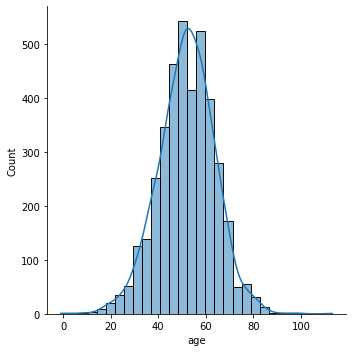

In [102]:
sns.displot(df_joined['age'], kde=True, bins=30) # Distribution of age values, Positive kurtosis and normal skewness

Nový atribút year_of_birth a atribút age s doplnenými chýbajúcimi hodnotami maju dobré normálové rozdelenie, s čím sa bude neskôr dobre pracovať.

# Riešenie chýbajúcich hodnôt

In [110]:
class FillNaNsWithMean(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        nan_map = X.isnull().any(axis=1)
        X[nan_map]

        imp = SimpleImputer(missing_values=np.nan, strategy='mean')
        for column_name in X:
            if X[column_name].dtypes != 'object':
                X[column_name] = imp.fit_transform(X[[column_name]])
                X[nan_map]

        return X
    
class FillNaNsWithMostFrequent(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        nan_map = X.isnull().any(axis=1)
        X[nan_map]

        imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        for column_name in X:
            if X[column_name].dtypes == 'object':
                X[column_name] = imp.fit_transform(X[[column_name]])
                X[nan_map]

        return X

## Nahradenie chýbajúcich hodnôt v číselných atribútoch pomocou stratégie priemeru

In [104]:
filling_nans_pipe = Pipeline(steps = [
    ('Filling NaNs with mean strategy', FillNaNsWithMean())
])

df_joined = filling_nans_pipe.transform(df_joined)

In [105]:
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3933 entries, 0 to 3982
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              3933 non-null   object 
 1   race              3933 non-null   object 
 2   marital-status    3540 non-null   object 
 3   occupation        3710 non-null   object 
 4   pregnant          3933 non-null   object 
 5   education-num     3933 non-null   float64
 6   relationship      3933 non-null   object 
 7   skewness_glucose  3933 non-null   float64
 8   mean_glucose      3933 non-null   float64
 9   capital-gain      3933 non-null   float64
 10  kurtosis_glucose  3933 non-null   float64
 11  education         3933 non-null   object 
 12  fnlwgt            3933 non-null   float64
 13  class             3933 non-null   float64
 14  std_glucose       3933 non-null   float64
 15  income            3933 non-null   object 
 16  native-country    3874 non-null   object 


### Zhrnutie doplňania chýbajúcich hodnôt pre číselné atribúty podľa stratégie priemeru
Doplnenie chýbajúcej hodnoty/hodnôt nezmenilo distribúciou, pretože sa väčšinou dopĺňala jedna, max 2 hodnoty. Tým pádom nebolo možné, aby takáto malá úprava zmenila distribúciu na takomto množstve záznamov, preto sme jednotlivé distribúcie ani nevykreslovi. Taktiež nie je potrebné vyskúšať ďalšie stratégie riešenia chýbajúcich hodnôt, pretože by  to bol minimálny rozdiel(ak vôbec nejaký) oproti tejto. 

## Riešenie chýbajúcich hodnôt v nečíselných atribútoch

In [111]:
most_frequent_pipe = Pipeline(steps = [
    ('Filling NaNs with most frequent strategy', FillNaNsWithMostFrequent())
])

df_joined = most_frequent_pipe.transform(df_joined)

In [112]:
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3933 entries, 0 to 3982
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              3933 non-null   object 
 1   race              3933 non-null   object 
 2   marital-status    3933 non-null   object 
 3   occupation        3933 non-null   object 
 4   pregnant          3933 non-null   object 
 5   education-num     3933 non-null   float64
 6   relationship      3933 non-null   object 
 7   skewness_glucose  3933 non-null   float64
 8   mean_glucose      3933 non-null   float64
 9   capital-gain      3933 non-null   float64
 10  kurtosis_glucose  3933 non-null   float64
 11  education         3933 non-null   object 
 12  fnlwgt            3933 non-null   float64
 13  class             3933 non-null   float64
 14  std_glucose       3933 non-null   float64
 15  income            3933 non-null   object 
 16  native-country    3933 non-null   object 


### Zhrnutie doplňania chýbajúcich hodnôt pre nečíselné atribúty podľa stratégie most frequent
Po vykonaní tohto kroku dataset neobsahuje chýbajúceho hodnoty a je pripravený na riešenie vychýlených hodnôt a náslendú transformáciu

# Riešenie vychýlených hodnôt

# Transformácia atribútu/ov pomocou Power transform (logaritmus, odmocnina a pod.)

# Transformácia nečíselných atribútov na číselné

# Opätovná realizácia podstatných častí prieskumnej analýzy
Očakáva sa že dokumentujete zmeny distribúcie hodnôt po realizácii predspracovania.

Následne dokumentujete LEN zmeny v prieskumnej analýze.